In [1]:
# Block 0: Import Libraries
import torch
import pyreadstat
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.nn.models import GAE
from torch_geometric.utils import from_networkx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
import networkx as nx
from node2vec import Node2Vec
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import numpy as np
import os
import logging
from matplotlib.lines import Line2D
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from collections import Counter

# Set device for PyTorch to store and run model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/Users/jeremyfrank/DeepGraph/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set up logging and standizes the log format for both the console and the text file
current_directory = os.getcwd()
log_file_path = os.path.join(current_directory, 'progress_log.txt')
logger = logging.getLogger()
logger.setLevel(logging.INFO)
if not logger.handlers:
    file_handler = logging.FileHandler(log_file_path)
    file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
    logger.addHandler(file_handler)

    console_handler = logging.StreamHandler()
    console_handler.setFormatter(logging.Formatter('%(message)s'))
    logger.addHandler(console_handler)

In [3]:
dataset_year = '2025'
dataset_name = "Reza_US20250623"
parent = os.path.dirname(current_directory) # Data is in the parent directory

dataset_path = os.path.join(parent, 'Data', dataset_year, dataset_name)
dataset = pyreadstat.read_sav(dataset_path + '.sav')[0]

#loops through all the dataframes and in the place of party id, if it is empty, input a 99 and for all other
#cells in the dataframe that are empty, input whatever number is associated with refused
for df in [dataset]:
    df.fillna(88, inplace=True)

# Choose questions to include in the dataset - focusing on political and social issues
dataset = df.filter(items=[
    'TRUD115',	    # Do you approve or disapprove of how President Trump is handling the economy?
    'TRUD146',	    # Do you approve or disapprove of how President Trump is handling immigration?
    'TRUD125',	    # Do you approve or disapprove of how President Trump is handling foreign policy?
    'USTHRTIR1',	# Do you think Iran is:
    'USIRATAG1',	# How much do you agree or disagree with the United States launching military airstrikes on three Iranian nuclear facilities:
    'USIRRET1',	    # How concerned are you that Iran will further retaliate against the United States in response to the airstrikes:
    'USMSIS1',	    # What kind of military support, if any, should the United States provide to Israel in a conflict with Iran:
    'PZCTRL1',	    # How much do you agree or disagree with the following statement: The President of the United States should obey federal court rulings even if the president does not like the ruling?
    'DEMS105',	    # Do you approve or disapprove of the job the Democrats in Congress are doing in office?
    'REPS105',	    # Do you approve or disapprove of the job the Republicans in Congress are doing in office?
    'THRTDEM1',	    # When thinking about the issues that divide the nation, do you think:
    'PBPMV1',	    # Do you think politically-motivated violence is:
    'PZ24VT',	    # Whom did you support in the 2024 presidential election:
    'PRIMMVW1',	    # Please choose the statement that comes closer to your own views even if neither is exactly right:
    'USDPSF1',	    # Do you think current U.S. deportation policies are making the country:
    'USDPT1A',	    # How much do you support or oppose the U.S. government deporting each of the following: Immigrants in the country without permanent legal status who have been convicted of a violent crime?
    'USDPT1B',	    # How much do you support or oppose the U.S. government deporting each of the following: Immigrants in the country without permanent legal status who have been convicted of a non-violent crime?
    'USDPT1C',	    # How much do you support or oppose the U.S. government deporting each of the following: Immigrants in the country without permanent legal status who work in certain industries such as agricultural or food service?
    'USDPT1D',	    # How much do you support or oppose the U.S. government deporting each of the following: Students who are in the U.S. on temporary visas that have expired?
    'USICEIM1',	    # How would you describe the actions of Immigration and Customs Enforcement (ICE) in enforcing immigration laws? Do you think they have:
    'VACLNG1',	    # Regardless of whether or not you are taking a summer vacation, what do you think is the ideal length for a summer vacation?
    'NWPROD1',  	# Do you usually try new products before other people do?
    'TRUDP105R',   	# Do you approve or disapprove of the job Donald Trump is doing as president? [And, would you say you strongly approve/disapprove of the job he is doing or just approve/disapprove?]
])

print(dataset.columns)


PyreadstatError: File /Users/jeremyfrank/DeepGraph/Deep_Graph_Generation/GraphOfPeople/Data/2025/Reza_US20250623.sav does not exist!

In [43]:
# Block 2: Identify and filter common columns
#set the columns to the question set of january first (might cause issues as we add other years questions but well see)
#Then in the data fram loops and sets the common columns as where these data frames overlap 

common_columns = set(dataset.columns)

    #for df in [february19, february26, april, august, november, dataset]:
        # common_columns = common_columns.intersection(set(df.columns))

    #january = january[common_columns]
    #february19 = february19[common_columns]
    #february26 = february26[common_columns]
    #april = april[common_columns]
    #august = august[common_columns]
    #november = november[common_columns]
    #dataset = dataset[common_columns]

In [44]:
# Block 3: Combine datasets
#combines all the datasets row wise and resets the index
        #combined_data = pd.concat([january, february19, february26, april, august, november, december], ignore_index=True)

#calculates the 10% (1/2 for the new line) of the total rows 
half_index = len(dataset) 

#selects the FIRST 10% of rows in teh datafram
subset_df = df[list(common_columns)]
combined_data = subset_df.iloc[:half_index]

In [45]:
# Block 4: Extract Features and Labels
#select partyID as our label column
label_column = 'PRTD5RW'
#y is half of decembers data (combined data) selecting the party id
y = combined_data[label_column]
# x is the rest of the data bc it drops party id
x = combined_data.drop(columns=[label_column])
# the nubmer of nodes is the length of the data
num_nodes = len(x)

feature_names = x.columns.tolist()

In [46]:
#Block 5: create graphs for each person in star where central node is person and 
# surrounding nodes are the column titles (well call them features)
def create_individual_graphs(UID, feature_vector):
    G = nx.Graph()
    center_node = f"person_{UID}"

    #add that central node
    G.add_node(center_node, type="person", label=label_column, id=UID)

    #connecting all of the feature/answer nodes into a star
    for feature in feature_names:
        feature_node = f"{center_node}_{feature}"
        G.add_node(feature_node, type="feature", feature=feature, value=feature_vector[feature])
        G.add_edge(center_node, feature_node)
    return G

#build the graphs by looping through the list of people and add them into a list
individual_graphs = []
for i in range(num_nodes):
    feature_vector = x.iloc[i]
    G_person = create_individual_graphs(i, feature_vector)
    individual_graphs.append(G_person)



In [47]:
#Block 6 building the large graph based on similarity
#large graph
G_large = nx.Graph()
G_large.add_nodes_from(range(num_nodes)) 

#getting the percent of matching answers
def similarity_comparison(row1, row2):
    matches = (row1 == row2).sum()
    return matches / len(row1)

#adding an edge if they share 60% of the same answers
cap = 0.6
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        sim = similarity_comparison(x.iloc[i], x.iloc[j])
        if sim >= cap:
            G_large.add_edge(i, j, weight = sim)

#storing each individual graph as a node attribute in the large graph
for i in range(num_nodes):
    G_large.nodes[i]["individual_graphs"] = individual_graphs[i]
    G_large.nodes[i]["label"] = y.iloc[i]



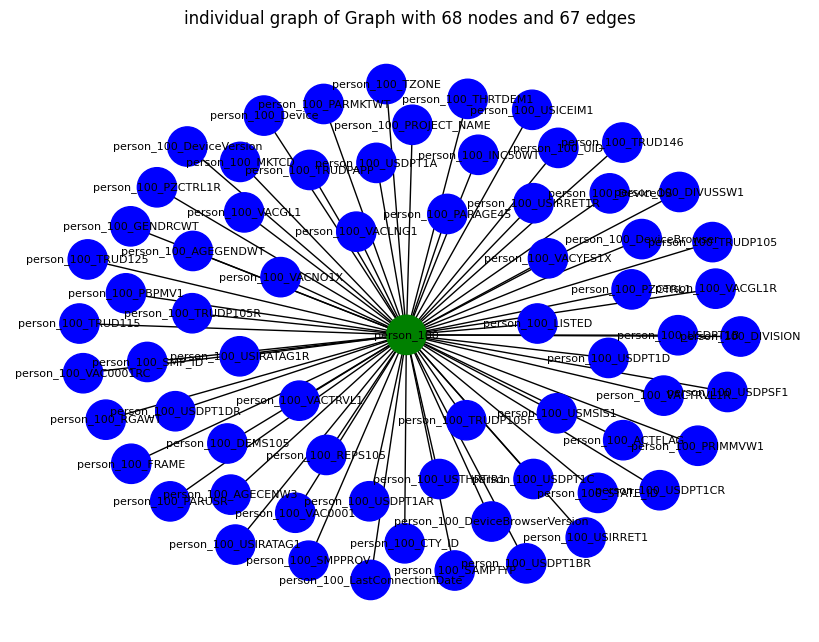

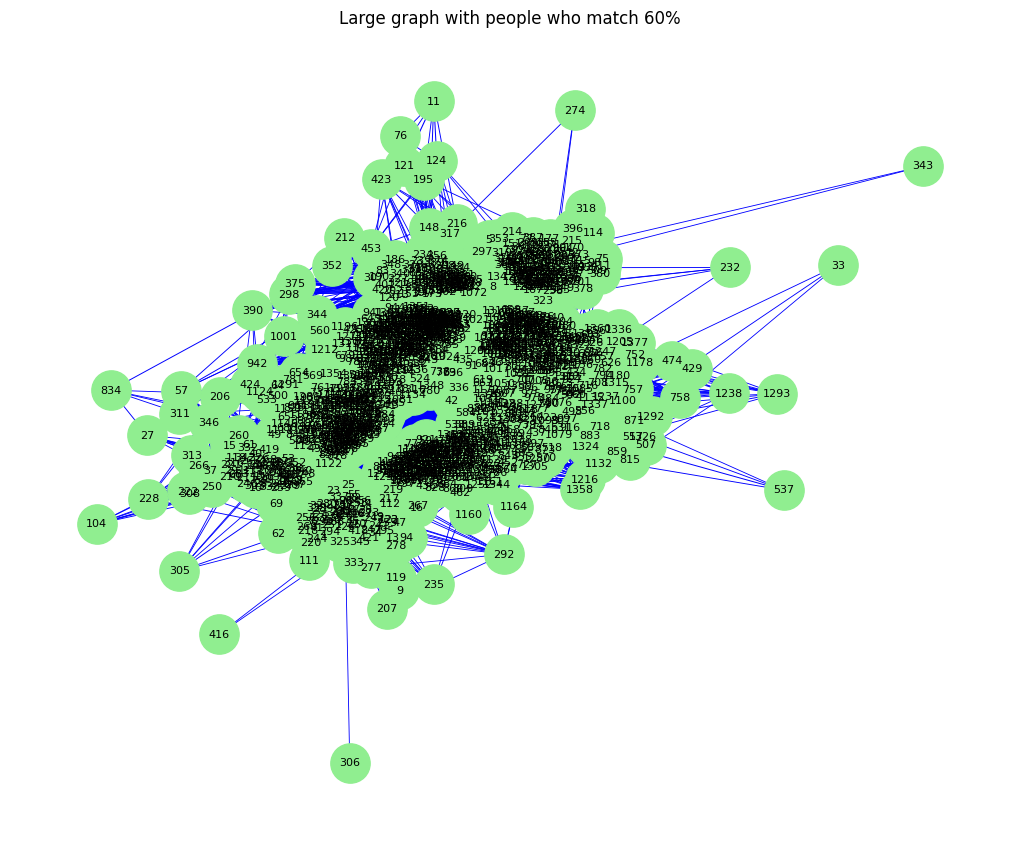

Nodes :1381, Edges: 117208
avg degrees: 169.74366401158582


In [48]:
# block 6.5 testing visuals for the graphs
def visualize_individual_graphs(G):
    plt.figure(figsize=(8,6))
    pos = nx.spring_layout(G)
    node_colors = ["blue" if data['type']=="feature" else 'green' for node, data in G.nodes(data=True)]

    nx.draw(G, pos, with_labels=True, node_color = node_colors, node_size=800, font_size=8)
    plt.title(f"individual graph of {G}")
    plt.show()

def visualize_large_graph(G_large):
    plt.figure(figsize=(10,8))
    pos = nx.spring_layout(G_large, seed=42)
    edge_weight = [G_large[u][v]['weight'] for u, v in G_large.edges()]

    nx.draw(G_large, pos, with_labels=True, node_color ='lightgreen', node_size=800, width=edge_weight, edge_color="blue", font_size=8)
    plt.title("Large graph with people who match 60%")
    plt.show()

visualize_individual_graphs(individual_graphs[100])
visualize_large_graph(G_large)
print(f"Nodes :{len(G_large.nodes())}, Edges: {len(G_large.edges())}")
degrees = [deg for nodes, deg in G_large.degree()]
print(f"avg degrees: {sum(degrees)/len(degrees)}")

In [49]:
# Block 7: Node2Vec Embeddings
#graph embeds node and edges, dimension(size of embedding vector for each node), walk length (steps per node), num_walk (how many walks per node), workers(cpu cores used)
node2vec = Node2Vec(G_large, dimensions=128, walk_length=10, num_walks=100, workers=4)
#sets parameters for walk
model_n2v = node2vec.fit(window=5, min_count=1, batch_words=4)
#creating a dictionary of node IDs connectd to embedded vectors
node_embeddings = {node: model_n2v.wv[str(node)] for node in G_large.nodes}
#puts the node embeddings into a dataframe (pandas)
embeddings_df = pd.DataFrame.from_dict(node_embeddings, orient='index').sort_index()

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:03<00:00,  6.27it/s]
collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
PROGRESS: at sentence #10000, processed 100000 words, keeping 1381 word types
PROGRESS: at sentence #20000, processed 200000 words, keeping 1381 word types
PROGRESS: at sentence #30000, processed 300000 words, keeping 1381 word types
PROGRESS: at sentence #40000, processed 400000 words, keeping 1381 word types
PROGRESS: at sentence #50000, processed 500000 words, keeping 1381 word types
PROGRESS: at sentence #60000, processed 600000 words, keeping 1381 word types
PROGRESS: at sentence #70000, processed 700000 words, keeping 1381 word types
PROGRESS: at sentence #80000, processed 800000 words, keeping 1381 word types
PROGRESS: at sentence #90000, processed 900000 words, keeping 1381 word types
PROGRESS: at sentence #100000, processed 1000000 words, keeping 1381 word types
PROGRESS: at sentence #110000, processe

In [50]:
# Block 8: GCN Encoder with Learnable Adjacency
class GCNEncoderWithAdjacency(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_nodes, dropout_rate=0.1):
        super().__init__()
        #2 hidden layers(input to hidden, then hidden to second hidden)
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.dropout_rate = dropout_rate
        #creates self learnable adjacency matrix
        self.learnable_adj = torch.nn.Parameter(torch.rand((num_nodes, num_nodes)))
        torch.nn.init.uniform_(self.learnable_adj, 0, 1)
# GCN forward pass 
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.conv2(x, edge_index)
        return x
#return adjacency matrix
    def get_adj_matrix(self):
        return torch.clamp(self.learnable_adj, 0, 1)

In [51]:
# Block 9: Build GAE
def build_gae_model(graph_embeddings, num_nodes):
    #returns numver of colmns in the data from
    input_dim = graph_embeddings.shape[1]
    #sets teh size of the hidden layer
    hidden_dim = 128
    #creates encoder and make it understanable to PyTorch
    encoder = GCNEncoderWithAdjacency(input_dim, hidden_dim, num_nodes)
    #wraps encoder inside GAE class
    return GAE(encoder)

model = build_gae_model(embeddings_df, num_nodes).to(device)

In [52]:
# Block 10: Prepare Data for PyTorch Geometric
def prepare_data_with_labels(graph_embeddings, labels, G_large):
    #converts features to PyTorch tensors which we need to use Geometric
    node_features = torch.tensor(graph_embeddings.values, dtype=torch.float32)
    
    UserID = df.columns.get_loc("UID")
    node_features = node_features.clone()
    node_features[:, UserID] = node_features[:, UserID].detach()

    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_tensor = torch.tensor(labels_encoded, dtype=torch.long)
    
    #makes sure we only keep valid nodes and edges and is used for error prevention
    valid_index_set = set(range(node_features.shape[0]))
    safe_edges = []
    weight= []
    for u,v,d in G_large.edges(data=True):
        if u in valid_index_set and v in valid_index_set:
            w = d.get('weight', 0.0)
            #add both directions
            safe_edges.append((u,v))
            safe_edges.append((v,u))
            weight.append(w)
            weight.append(w)

    edge_index = torch.tensor(safe_edges, dtype=torch.long).t().contiguous()
    edge_weight = torch.tensor(weight, dtype=torch.float)
    #converts data to again, be understood by Geometric
    data_pyg = from_networkx(G_large)
    data_pyg.x = node_features
    data_pyg.edge_index = edge_index
    data_pyg.y = labels_tensor[:node_features.shape[0]]
    data_pyg.edge_weight = edge_weight

    #returning that data that was just converted
    return data_pyg, {i: label for label, i in zip(label_encoder.classes_, range(len(label_encoder.classes_)))}


data_pyg, label_mapping = prepare_data_with_labels(embeddings_df, y, G_large)

In [53]:
# Block 11: Custom Loss
#helps the model to get similar nodes closer and different node further while taking label and weight into accound
def custom_loss(node_features, edge_index, edge_weight):
    #filter unvalid edges
    src, dst = edge_index
    valid_mask = (src < node_features.size(0)) & (dst < node_features.size(0))
    src = src[valid_mask]
    dst = dst[valid_mask]
    edge_weight = edge_weight[valid_mask]

    #weighted loss
    #get distance
    edge_dist = torch.norm(node_features[src] - node_features[dst], dim=1)

    #creating base weight
    base_weight = (edge_weight - edge_weight.min())/ (edge_weight.max() - edge_weight.min())

    #encourage stronger weights
    same_edge_loss = base_weight * (edge_dist ** 2)
    #discourage lower weights
    diff_edge_loss = (1 - base_weight)* ((1.0/(1.0 + edge_dist)) ** 2)
    #normalize it
    edge_loss = torch.sum(same_edge_loss + diff_edge_loss) / edge_weight.numel()

    return edge_loss




In [54]:
# Block 12: Save Adjacncy Matrix and Edges

def save_graph_image(adj_matrix, epoch):
    plt.figure(figsize=(6, 6))
    plt.imshow(adj_matrix.detach().cpu().numpy(), cmap='hot', interpolation='nearest')
    plt.title(f"Adjacency Matrix - Epoch {epoch+1}")
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(f"graphs/adj_matrix_epoch_{epoch+1}.png")
    plt.close()

index_to_id = df["UID"].to_dict()

def save_edges_to_file(adj_matrix, epoch, index_to_id, threshold=0.6):
    #compares the elements in the adjacency matrix and returns the indices where the entry is >= .6
    edges = (adj_matrix >= threshold).nonzero(as_tuple=False)
    with open(f"edges/edges_epoch_{epoch+1}.txt", 'w') as f:
        for i, j in edges:
            i_idx = i.item()
            j_idx = j.item()
            weight = adj_matrix[i_idx, j_idx].item()
            id_i = index_to_id.get(i_idx)
            id_j = index_to_id.get(j_idx)
            f.write(f"{id_i}, {id_j}, {weight}\n")

In [55]:
# Block 13: Plot Losses

def plot_performance(train_loss_values, val_loss_values):
    plt.figure()
    plt.plot(range(1, len(train_loss_values) + 1), train_loss_values, marker='o', label="Training Loss")
    plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, marker='s', label="Validation Loss", linestyle='dashed')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss over Epochs")
    plt.legend()
    plt.savefig("training_validation_loss.png")
    plt.close()

In [56]:
# Block 14: Train GAE
def train_gae_model(model, data, epochs=5, learning_rate=0.001, alpha=0.1, adj_lambda=0.01):
    print(">>> TRAINING BEGINNING <<<")
    #sets up ADAM optimizer, 
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Moves the node features (x), graph edges(edge_index), and labels(y) to the GPU or CPU
    data.x, data.edge_index, data.y = data.x.to(device), data.edge_index.to(device), data.y.to(device)

    # runs the encoder to get node embeddings for the full graph Z
    z_full = model.encode(data.x, data.edge_index)

    # Split into train/test based on node indices, used for supervised loss evaluation
    # splits the node indices into 80% training and 20% testing
    node_indices = np.arange(z_full.shape[0])
    train_indices, test_indices = train_test_split(node_indices, test_size=0.2, random_state=42)

    #extracting training and testing embeddings and labels to use when we call custom_loss
    X_train = z_full[train_indices]
    X_test = z_full[test_indices]
    y_train = data.y[train_indices]
    y_test = data.y[test_indices]

    #creating folders to save epoch outputs
    os.makedirs('graphs', exist_ok=True)
    os.makedirs('edges', exist_ok=True)

    #stores loss values for plotting
    train_losses, val_losses = [], []

    #loops through epoches
    for epoch in range(epochs):
        #sets model to train and resets previous gradietns
        model.train()
        optimizer.zero_grad()

        # Re-encode full graph at every epoch 
        # and gets the adjacency matrix 
        z_full = model.encode(data.x, data.edge_index)
        learned_adj = model.encoder.get_adj_matrix()

        #how well the model predicts edges
        bce_loss = model.recon_loss(z_full, data.edge_index)
        #custom loss
        c_loss = custom_loss(z_full[train_indices], data.edge_index, data.edge_weight)
        #penalty to keep the learned adjacency matrix from getting too far off track
        adj_loss = adj_lambda * torch.norm(learned_adj - model.encoder.learnable_adj)
        #combines them
        total_loss = alpha * bce_loss + (1 - alpha) * c_loss + adj_loss

        print(f"Epoch {epoch+1} | Train BCE: {bce_loss.item():.4f} | Cls: {c_loss.item():.4f} | Adj: {adj_loss.item():.4f} | Total: {total_loss.item():.4f}")

        #runs back propagation, optimizes model weights, saves loss for plotting
        total_loss.backward()
        optimizer.step()
        train_losses.append(total_loss.item())

        #saves graphs
        index_to_id = df["UID"].to_dict()
        save_graph_image(learned_adj, epoch)
        save_edges_to_file(learned_adj, epoch, index_to_id)

        # Validation mode set
        model.eval()
        # calcs with no gradient so its faster and safer
        with torch.no_grad():
            z_val_full = model.encode(data.x, data.edge_index)
            bce_val_loss = model.recon_loss(z_val_full, data.edge_index)
            c_loss_val = custom_loss(z_val_full[test_indices], data.edge_index, data.edge_weight)
            total_val_loss = alpha * bce_val_loss + (1 - alpha) * c_loss_val
            val_losses.append(total_val_loss.item())

            print(f"Validation Loss: {total_val_loss.item():.4f}")
    # done and plots the epoch's loss 
    print(">>> TRAINING COMPLETE <<<")
    plot_performance(train_losses, val_losses)

    return model, X_test, y_test

In [57]:
# Block 15: Execute Original Training

trained_model, X_test, y_test = train_gae_model(model, data_pyg, epochs=50)



>>> TRAINING BEGINNING <<<
Epoch 1 | Train BCE: 1.5604 | Cls: 0.4146 | Adj: 0.0000 | Total: 0.5292
Validation Loss: 0.5316
Epoch 2 | Train BCE: 1.4076 | Cls: 0.4058 | Adj: 0.0000 | Total: 0.5060
Validation Loss: 0.5130
Epoch 3 | Train BCE: 1.3336 | Cls: 0.4031 | Adj: 0.0000 | Total: 0.4961
Validation Loss: 0.5051
Epoch 4 | Train BCE: 1.3006 | Cls: 0.4038 | Adj: 0.0001 | Total: 0.4936
Validation Loss: 0.5025
Epoch 5 | Train BCE: 1.2826 | Cls: 0.4047 | Adj: 0.0001 | Total: 0.4926
Validation Loss: 0.5021
Epoch 6 | Train BCE: 1.2717 | Cls: 0.4050 | Adj: 0.0001 | Total: 0.4918
Validation Loss: 0.5032
Epoch 7 | Train BCE: 1.2593 | Cls: 0.4045 | Adj: 0.0001 | Total: 0.4901
Validation Loss: 0.5053
Epoch 8 | Train BCE: 1.2476 | Cls: 0.4042 | Adj: 0.0001 | Total: 0.4887
Validation Loss: 0.5087
Epoch 9 | Train BCE: 1.2362 | Cls: 0.4047 | Adj: 0.0001 | Total: 0.4880
Validation Loss: 0.5126
Epoch 10 | Train BCE: 1.2259 | Cls: 0.4055 | Adj: 0.0001 | Total: 0.4876
Validation Loss: 0.5162
Epoch 11 | T

/Users/jeremyfrank/DeepGraph/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


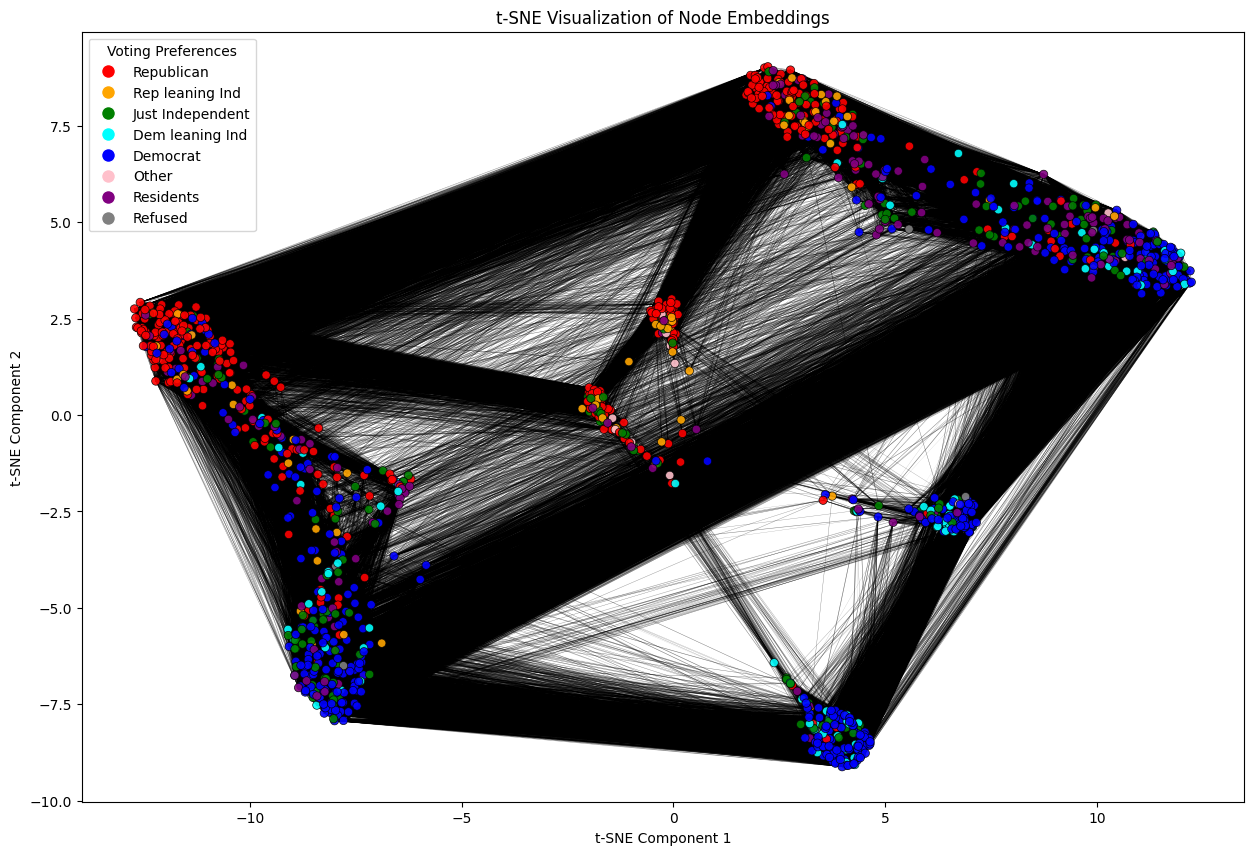

In [58]:
# Block 16: visualize embeddings and graphs
# Commented out for the time being to save time. Run the next cell instead for KMeans.
from matplotlib.lines import Line2D
import random

def visualize_embeddings(embeddings, labels, label_mapping, edge_index=None, adj_matrix=None, method='t-SNE'):
    # Convert PyTorch tensor to NumPy array
    embeddings_np = embeddings.detach().cpu().numpy()
    # Convert labels tensor to numpy array
    labels_np = labels.cpu().numpy() 

    # Reverse the label mapping to map encoded values to the original labels
    reverse_label_mapping = {0:1.0, 1:2.0, 2:3.0, 3:4.0, 4:5.0, 5:97.0, 6:98.0, 7:99.0}

    # Map the numerical labels to their original values using reverse mapping
    original_labels = np.array([reverse_label_mapping[label] for label in labels_np])

    # Change labels to Political Parties
    label_names = {1.0: "Democrat", 2.0:"Dem leaning Ind",3.0: "Just Independent", 4.0:"Rep leaning Ind", 5.0: "Republican",
                    97.0:"Other", 98.0:"Residents", 99.0:"Refused"}
    #label_names = [label_names.get(label, "Other") for label in original_labels]

    #filtering the party labels to only show the 3
    mask = np.isin(original_labels, list(label_names.keys()))
    embeddings_np = embeddings_np[mask]
    original_labels = original_labels[mask]

    readable_lables = np.array([label_names[label] for label in original_labels])

    # Reduce the dimensions of embeddings
    if method == 'PCA':
        reducer = PCA(n_components=2)
    elif method == 't-SNE':
        perplex = min(30, (embeddings_np.shape[0]-1)//3)
        reducer = TSNE(n_components=2, random_state=42, perplexity=200)
    else:
        raise ValueError("Method must be either PCA or 't-SNE'.")

    reduced_embeddings = reducer.fit_transform(embeddings_np)

    # Create a color map for the labels
    color_map = {
        "Republican": 'red',
        "Rep leaning Ind": 'orange',
        "Democrat": 'blue',
        "Dem leaning Ind": 'cyan',
        "Just Independent": 'green',
        "Other":'pink',
        "Residents": 'purple',
        "Refused": 'gray'
    }
    node_colors = [color_map[label] for label in readable_lables]

    # Plot the reduced embeddings
    plt.figure(figsize=(15,10))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=node_colors, alpha=0.9, edgecolor='black', linewidths=0.5, zorder=2)
    
    edge_index_np = edge_index.cpu().numpy()
    #want to get the indices of our fitered nodes
    mask_indices = np.where(mask)[0]
    #maps where the node was originally to its new possition
    index_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(mask_indices)}
    #each loop we'll get one edge source and destination
    for src, dst in edge_index_np.T:
        #getting the coords
        if src in index_mapping and dst in index_mapping:
            src_2 = reduced_embeddings[index_mapping[src]]
            dst_2 = reduced_embeddings[index_mapping[dst]]
            weight = adj_matrix[src, dst].item() if adj_matrix is not None else .05
            plt.plot([src_2[0], dst_2[0]], [src_2[1], dst_2[1]], color="black", alpha=0.3, linewidth=weight/2, zorder=1)

        # Add legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Republican', markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Rep leaning Ind', markerfacecolor='orange', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Just Independent', markerfacecolor='green', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Dem leaning Ind', markerfacecolor='cyan', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Democrat', markerfacecolor='blue', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Other', markerfacecolor='pink', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Residents', markerfacecolor='purple', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Refused', markerfacecolor='gray', markersize=10),
    ]
    plt.legend(handles=legend_elements, title="Voting Preferences")
    plt.title(f"{method} Visualization of Node Embeddings")
    plt.xlabel(f"{method} Component 1")
    plt.ylabel(f"{method} Component 2")
    plt.show()

# Get learned embeddings and visualize them
with torch.no_grad():
    z = trained_model.encode(data_pyg.x.to('cpu'), data_pyg.edge_index.to('cpu'))
    adj_matrix = trained_model.encoder.learnable_adj.detach().cpu()
    visualize_embeddings(z, data_pyg.y, label_mapping, data_pyg.edge_index, adj_matrix, method='t-SNE')


/Users/jeremyfrank/DeepGraph/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jeremyfrank/DeepGraph/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[1 3 0 ... 5 2 6]


/Users/jeremyfrank/DeepGraph/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


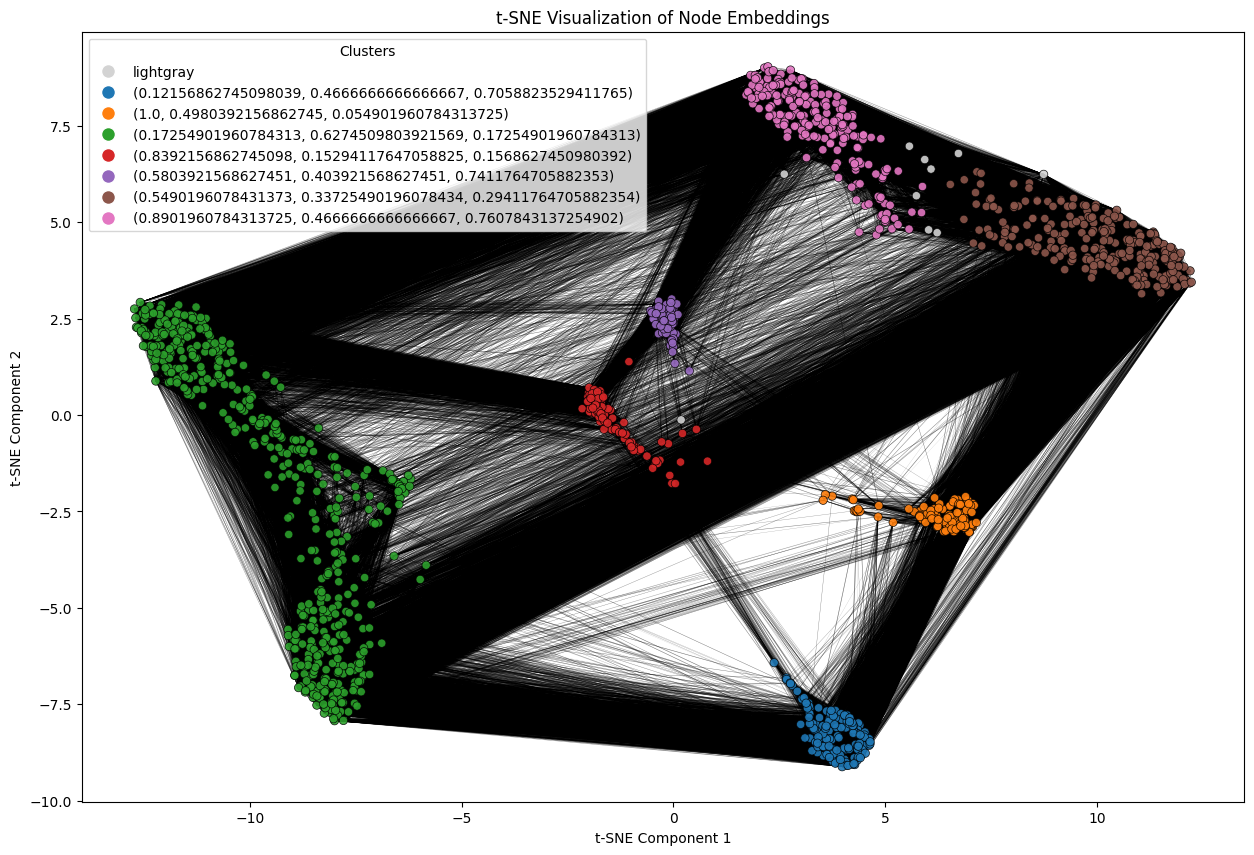

Noise points: 10


NameError: name 'labels_for_legend' is not defined

In [60]:
import hdbscan

def visualize_embeddings_with_HDBSCAN(embeddings, labels, label_mapping, edge_index=None, adj_matrix=None, method='t-SNE'):
    # Convert PyTorch tensor to NumPy array
    embeddings_np = embeddings.detach().cpu().numpy()
    # Convert labels tensor to numpy array
    labels_np = labels.cpu().numpy() 

    # Reverse the label mapping to map encoded values to the original labels
    reverse_label_mapping = {0:1.0, 1:2.0, 2:3.0, 3:4.0, 4:5.0, 5:97.0, 6:98.0, 7:99.0}

    # Map the numerical labels to their original values using reverse mapping
    original_labels = np.array([reverse_label_mapping[label] for label in labels_np])

    # Change labels to Political Parties
    label_names = {1.0: "Democrat", 2.0:"Dem leaning Ind",3.0: "Just Independent", 4.0:"Rep leaning Ind", 5.0: "Republican",
                    97.0:"Other", 98.0:"Residents", 99.0:"Refused"}
    #label_names = [label_names.get(label, "Other") for label in original_labels]

    #filtering the party labels to only show the 3
    mask = np.isin(original_labels, list(label_names.keys()))
    embeddings_np = embeddings_np[mask]
    original_labels = original_labels[mask]

    readable_lables = np.array([label_names[label] for label in original_labels])

    # Reduce the dimensions of embeddings
    if method == 'PCA':
        reducer = PCA(n_components=2)
    elif method == 't-SNE':
        perplex = min(30, (embeddings_np.shape[0]-1)//3)
        reducer = TSNE(n_components=2, random_state=42, perplexity=200)
    else:
        raise ValueError("Method must be either PCA or 't-SNE'.")

    reduced_embeddings = reducer.fit_transform(embeddings_np)

    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=50,
        min_samples=5,
        metric='euclidean',
        cluster_selection_epsilon=0.2,
        cluster_selection_method='eom'
    )
    cluster_labels = clusterer.fit_predict(reduced_embeddings) # Create clusters
    #labels = cluster_labels.labels_
    print(cluster_labels)
    #print(labels)
    
    unique_labels = set(cluster_labels)
    num_clusters = len(set(unique_labels)) - (1 if -1 in unique_labels else 0)
    
    # Create a color map for the labels
    unique_clusters = np.unique(cluster_labels)
    colors = plt.cm.tab10.colors  # or whatever colormap you used

    # Create a color map dict
    cluster_to_color = {
        # Dynamic color assignment
        cluster: ('lightgray' if cluster == -1 else colors[cluster % len(colors)])
        for cluster in unique_clusters
        
        # Static color assignment for up to 4 clusters + noise
        #-1: 'lightgray',
        #0: 'orange',
        #1: 'green',
        #2: 'red',
        #3: 'blue',
    }
    node_colors = [cluster_to_color[cluster] for cluster in cluster_labels]
    

    # Plot the reduced embeddings
    plt.figure(figsize=(15,10))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=node_colors, alpha=0.9, edgecolor='black', linewidths=0.5, zorder=2)

    
    edge_index_np = edge_index.cpu().numpy()
    #want to get the indices of our fitered nodes
    mask_indices = np.where(mask)[0]
    #maps where the node was originally to its new position
    index_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(mask_indices)}
    #each loop we'll get one edge source and destination
    
    for src, dst in edge_index_np.T:
        #getting the coords
        if src in index_mapping and dst in index_mapping:
            src_2 = reduced_embeddings[index_mapping[src]]
            dst_2 = reduced_embeddings[index_mapping[dst]]
            weight = adj_matrix[src, dst].item() if adj_matrix is not None else .05
            plt.plot([src_2[0], dst_2[0]], [src_2[1], dst_2[1]], color="black", alpha=0.3, linewidth=weight/2, zorder=1)

    #HARD CODED LEGEND TITLES
    '''labels_for_legend = {
        -1: "Noise",
        0: "Mysterious Cluster",
        1: "Independent values",
        2: "Conservative values",
        3: "Liberal values",
    }'''
    
    # Build legend dynamically
    legend_elements = []
    for cluster, color in cluster_to_color.items():
        label = cluster_to_color.get(cluster, f"Cluster {cluster}") #DYNAMIC LABELS
        legend_elements.append(
            Line2D(
                [0], [0],
                marker='o', color='w',
                label=label,
                markerfacecolor=color,
                markersize=10
            )
        )

    plt.legend(handles=legend_elements, title="Clusters")
    plt.title(f"{method} Visualization of Node Embeddings")
    plt.xlabel(f"{method} Component 1")
    plt.ylabel(f"{method} Component 2")
    plt.show()
    
    #Print statistics about clusters
    for cluster in unique_clusters:
        cluster_size = np.sum(cluster_labels == cluster)
        if cluster == -1:
            print(f"Noise points: {cluster_size}")
        else:
            num_dems = np.sum(readable_lables[cluster_labels == cluster] == 'Democrat') + np.sum(readable_lables[cluster_labels == cluster] == 'Dem leaning Ind')
            num_reps = np.sum(readable_lables[cluster_labels == cluster] == 'Republican') + np.sum(readable_lables[cluster_labels == cluster] == 'Rep leaning Ind')
            num_ind = np.sum(readable_lables[cluster_labels == cluster] == 'Just Independent')
            num_res = np.sum(readable_lables[cluster_labels == cluster] == 'Residents')
            
            print(f"{labels_for_legend.get(cluster)}: ")
            print(f" - Total: {cluster_size}")
            print(f" - Registered Democrats: {num_dems} ({(num_dems/cluster_size)*100:.2f}%)")
            print(f" - Registered Republicans: {num_reps} ({(num_reps/cluster_size)*100:.2f}%)")
            print(f" - Registered Independents: {num_ind} ({(num_ind/cluster_size)*100:.2f}%)")
            print(f" - Residents {num_res} ({(num_res/cluster_size)*100:.2f}%)")
            
    return cluster_labels



# Get learned embeddings and visualize them
with torch.no_grad():
    z = trained_model.encode(data_pyg.x.to('cpu'), data_pyg.edge_index.to('cpu'))
    adj_matrix = trained_model.encoder.learnable_adj.detach().cpu()
    cluster_labels = visualize_embeddings_with_HDBSCAN(z, data_pyg.y, label_mapping, data_pyg.edge_index, adj_matrix, method='t-SNE')

In [ ]:
# Calculate cluster densities
for cluster_id in set(cluster_labels):
    if cluster_id == -1:
        continue  # Skip noise
    total = np.sum(cluster_labels == cluster_id)
    print(f"Cluster {cluster_id}: Size = {cluster_size}")

In [ ]:
# Calculate percentage of nodes in each cluster

for i in range(optimal_k):
    cluster_size = np.sum(cluster_labels == i)
    print(f"Cluster {i} size: {cluster_size} nodes")
    percentage = (cluster_size / len(cluster_labels)) * 100
    print(f"Cluster {i}: {percentage:.2f}% of nodes")

In [ ]:
#Implement k-means clustering on the embeddings to find metrics for different k values
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#Metrics to evaluate clustering
K_RANGE = range(2, 4)
inertias = []
sil_scores = []

for k in K_RANGE:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42).fit(reduced_embeddings)

    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(reduced_embeddings, kmeans.labels_))
    
#Plot the metrics
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(list(K_RANGE), inertias, marker='o')
ax[0].set_title("Elbow plot (WCSS vs k)")
ax[0].set_xlabel("k"); ax[0].set_ylabel("WCSS (inertia_)")

ax[1].plot(list(K_RANGE), sil_scores, marker='o')
ax[1].set_title("Silhouette score vs k")
ax[1].set_xlabel("k"); ax[1].set_ylabel("Silhouette")
plt.tight_layout(); plt.show()

NameError: name 'reduced_embeddings' is not defined

In [ ]:
# Implement K-Means clustering with the optimal k
optimal_k = 3  # Set based on the elbow and silhouette plots
kmeans_final = KMeans(n_clusters=optimal_k, n_init=10, random_state=42).fit(reduced_embeddings)
cluster_labels = kmeans_final.labels_





In [ ]:
z = trained_model.encode(data_pyg.x.to('cpu'), data_pyg.edge_index.to('cpu'))
embeddings = z
embeddings_np = embeddings.detach().cpu().numpy()
print(embeddings_np.shape[0])

3131


In [ ]:
#test
print(z.shape)
print(data_pyg.y.shape)
print(type(label_mapping), label_mapping)
print(np.isnan(z).any())
print(np.unique(data_pyg.y))

torch.Size([3131, 128])
torch.Size([3131])
<class 'dict'> {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0, 5: 97.0, 6: 98.0, 7: 99.0}


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

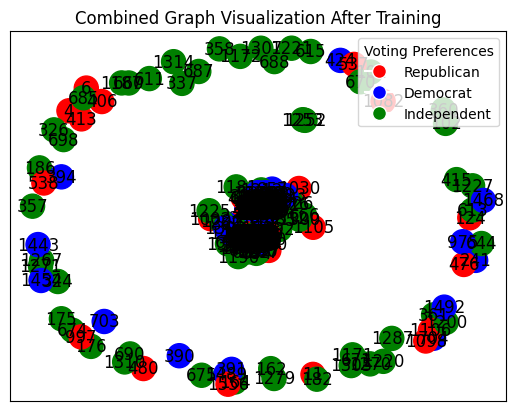

OrderedDict([('encoder.learnable_adj', tensor([[0.5649, 0.7993, 0.1593,  ..., 0.0947, 0.0513, 0.1140],
        [0.1311, 0.0019, 0.3317,  ..., 0.2997, 0.1459, 0.0180],
        [0.1136, 0.2339, 0.6955,  ..., 0.4967, 0.5988, 0.5319],
        ...,
        [0.9256, 0.9541, 0.9760,  ..., 0.0022, 0.7387, 0.8028],
        [0.9586, 0.6939, 0.7233,  ..., 0.6179, 0.6380, 0.8172],
        [0.4846, 0.1322, 0.2678,  ..., 0.4466, 0.0422, 0.6266]])), ('encoder.conv1.bias', tensor([ 0.0021, -0.0099, -0.0014,  0.0178,  0.0027, -0.0117,  0.0107,  0.0200,
        -0.0045, -0.0116,  0.0203, -0.0040,  0.0056,  0.0195,  0.0095, -0.0100,
         0.0145, -0.0016,  0.0015, -0.0062,  0.0077,  0.0130, -0.0086,  0.0188,
         0.0034, -0.0067,  0.0026,  0.0080, -0.0038,  0.0057, -0.0057,  0.0060,
         0.0206, -0.0124,  0.0206, -0.0008,  0.0008,  0.0093, -0.0047, -0.0053,
         0.0058,  0.0199,  0.0022,  0.0086,  0.0084, -0.0029, -0.0119,  0.0078,
         0.0146,  0.0123,  0.0180, -0.0035,  0.0151, -0.00

In [ ]:
# Block 18: combined graph
from collections import Counter
def visualize_graph_sample(graphs, labels, label_mapping, num_graphs=5, random_seed=42):

    # Set random seed for reproducibility
    random.seed(random_seed)

    # Convert labels tensor to numpy array
    labels_np = labels.cpu().numpy()

    # Reverse the label mapping to map encoded values to the original labels
    reverse_label_mapping = {0:1.0, 1:3.0, 2:5.0, 3:81.0, 4:82.0, 5:83.0, 6:84.0, 7:85.0, 8:86.0, 9:87.0, 10:97.0, 11:98.0, 12:99.0}

    # Map the numerical labels to their original values using reverse mapping
    original_labels = [reverse_label_mapping.get(label, None) for label in labels_np]
    
    # Change labels to Political Parties
    label_names = {1.0: "Democrat", 3.0: "Independent", 5.0: "Republican"}
    
    # Randomly select a sample of graphs
    selected_indices = random.sample(range(len(graphs)), min(num_graphs, len(graphs)))
    selected_graphs = [graphs[i] for i in selected_indices]

    # Loop through selected graphs
    for idx, G in enumerate(selected_graphs):
        #plt.figure(figsize=(15,10))
        #pos = nx.spring_layout(G, seed=random_seed)
        filtered_nodes = [
        node for node in G.nodes()
        if node < len(original_labels) and original_labels[node] in label_names]
        
        #creating subgraphs
        subG = G.subgraph(filtered_nodes)
        pos = nx.spring_layout(subG, seed=random_seed)

    
        # Create node colors based on the labels
        color_mapping = []
        for node in subG.nodes():
            original_label = original_labels[node]
            party = label_names.get(original_label, "Other")
            color_mapping.append(party)
        # #label = G.nodes[node].get('label')
        #original_label = reverse_label_mapping.get(label, None)
        #if original_label in label_names:
            #color_mapping.append(label_names[original_label])
        #else:
            #color_mapping.append("Other")
        
        #    if original_label in label_names:
        #        color_mapping.append(label_names[original_label])
        #   else:
        #       color_mapping.append("Other") # If label is not in label_names
        #  else:
        #    color_mapping.append("Other") # If node doesn't have corresponding label

        # Color scheme for labels
        node_colors = []
        for label in color_mapping:
            if label == "Republican":
                node_colors.append('red')
            elif label == "Democrat":
                node_colors.append('blue')
            elif label == "Independent":
                node_colors.append('green')
            else:
                node_colors.append('yellow')

        # Draw the graph with nodes colored by voting preferences
        nx.draw_networkx(subG, pos, with_labels=True, node_color=node_colors, node_size=300, font_color='black', edge_color='gray')

        # Create a legend for voting preferences
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='Republican', markerfacecolor='red', markersize=10),
            Line2D([0], [0], marker='o', color='w', label='Democrat', markerfacecolor='blue', markersize=10),
            Line2D([0], [0], marker='o', color='w', label='Independent', markerfacecolor='green', markersize=10)
        ]
        plt.legend(handles=legend_elements, title="Voting Preferences")
        plt.title("Combined Graph Visualization After Training")
        plt.show()
        #print("Sample labels_np:", labels_np[:10])
        #print("Reverse mapping:", reverse_label_mapping)

    # How many nodes fall into each party (mapped back from labels_np)?
    #label_counts = Counter(original_labels)
    #print("Original label counts:", label_counts)
    #print("Unique label values in labels_np:", set(labels_np))
    #print("Keys in reverse_label_mapping:", set(reverse_label_mapping.keys()))

# List of graphs
graphs_list = [G_large]

visualize_graph_sample(graphs_list, data_pyg.y, label_mapping, num_graphs=5)
print(model.state_dict())

In [ ]:
#Block 18: Anaylsis
#we want to find which questions are most important to each group on average

#Forest Classifier will tell us which questions are teh most important in telling the different parties apart
a = trained_model.encode(data_pyg.x.to('cpu'), data_pyg.edge_index.to('cpu'))
b = trained_model.encode(data_pyg.y.to('cpu'), data_pyg.edge_index.to('cpu'))
#fit full data
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(a, b)


#Get Question permutation importance
importance = permutation_importance(rf, a, b, n_repeats=10, random_state=42)
feature_names = x.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Top important features to distinguish parties:")
print(importance_df.head(10))


#Mean Difference Analysis will tell us which questions distingish each party based on average responses
#group data by y label and get the means
group_means = x.groupby(y).mean()

#dictionary for max pairwise mean difference per column
feature_diff = {}


for group in group_means.index:
    #average for all other groups
    others = group_means.drop(group)
    #absolute difference from this groups mean
    diff = group_means.loc[group] - others.mean()
    feature_diff[group] = diff.abs()

#convert to datafram
feature_diff_df = pd.DataFrame(feature_diff)

#display the top 10 per group
for group in feature_diff_df.columns:
    print(f"Top features to distinguish {group}:")
    print(feature_diff_df[group].sort_values(ascending=False).head(10))
    top5 = feature_diff_df[group].sort_values(ascending=False).head(10)

    plt.figure(figsize=(8,5))
    top5.plot(kind='barh', color='lightblue')
    plt.gca().invert_yaxis()
    plt.title("Top Features to distinguish {group}")
    plt.xlabel("ABS Mean Difference")
    plt.tight_layout()
    plt.show()

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got -2)

In [ ]:
# More analysis for each group, tells us the average top 10(k) learned edge weights connected to nodes within that group
def avg_top_weights_for_parties(model, data, k=10):
    #get the learned adj
    adj = model.encoder.learnable_adj.detach().cpu()
    num_nodes = adj.size
    #get the party lables for each node
    partys = data.y.detach().cpu().numpy()
    #get rid of repeats
    unique_party = np.unique(partys)

    results = {}

    for party in unique_party:
        #find the nodes in the party
        party_node_indices = np.where(partys == party)[0]

        #get teh submatrix edges from these nodes to all other nodes
        sub_adj = adj[party_node_indices, :]

        #flattens the matrix into a 1D tensor 
        edge_weights = sub_adj.flatten()
        #filters out 0s weights
        edge_weights = edge_weights[edge_weights>0]

        #set avg to 0 to start
        if len(edge_weights)==0:
            avg_top = 0.0
        else: 
            #gets the top k edge weights and takes the mean of those weights
            top_k = torch.topk(edge_weights, min(k, edge_weights.size(0))).values
            avg_top = top_k.mean().item()

        results[int(party)] = avg_top
    return results

lable_map = {
    1.0: "Democrat", 3.0: "Independent", 5.0: "Republican", 81.0: "Conservative", 82.0: "Liberal", 83.0: "Independece/Reform", 
    84.0: "Green", 85.0: "Right to life", 86.0: "Working families", 87.0: "Libertarian", 97.0: "Other", 98.0: "Unsure", 99.0: "Refused"
}

results = avg_top_weights_for_parties(model, data_pyg, k=10)
reverse_label_mapping = {0:1.0, 1:3.0, 2:5.0, 3:81.0, 4:82.0, 5:83.0, 6:84.0, 7:85.0, 8:86.0, 9:87.0, 10:97.0, 11:98.0, 12:99.0}
for party, avg in results.items():
    party_name = reverse_label_mapping.get(party, f"Group {party}")
    print(f"{party_name}: Avg of top 10 edge weights = {avg: .4f}")

1.0: Avg of top 10 edge weights =  0.9018
3.0: Avg of top 10 edge weights =  0.9018
5.0: Avg of top 10 edge weights =  0.9018
81.0: Avg of top 10 edge weights =  0.9002
82.0: Avg of top 10 edge weights =  0.8988
83.0: Avg of top 10 edge weights =  0.9017
84.0: Avg of top 10 edge weights =  0.9013
85.0: Avg of top 10 edge weights =  0.9018
